In [48]:
import re
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
from scipy import sparse

In [43]:
def ohe(seq):
    seq2=list()
    mapping = {"A":[1., 0., 0., 0.], "C": [0., 1., 0., 0.], "G": [1., 0., 0., 0.], "T":[0., 0., 0., 1.]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0., 0., 0., 0.]) 
    return np.array(seq2)

[1.0, 0.0, 0.0, 0.0]

In [5]:
#fasta to ohe
f=open('/home/florian/projet/r6.16/dmel-all-chromosome-r6.16.fasta','r')
os.chdir('/home/florian/projet/r6.16')
chr_name = str()
seq=[]
D={}
for line in f:
        line = line.rstrip()
        if line[0] == '>':
                if line[1:3]=="2C":
                        break
                if seq != []:
                        D[chr_name]=ohe(seq)
                chr_name = line[1:3]
                seq = []
        else:
                seq += line
D["Y"]=ohe(seq)
np.savez_compressed('seq',**D)

In [36]:
#bigwig to numpy
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs, mins, maxs = [], [], []
for file in fichiers:
    print("processing file", file)
    bw=pbg.open(file)
    array = np.concatenate((bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True)))
    mins.append(array.min())
    maxs.append(array.max())
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array


processing file unk_18b.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_03.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_10b.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_07.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_04c.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_13.dedup.no_blacklist.RPGCnormalized.bw
processing file Ensheathingglia.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_10f.dedup.no_blacklist.RPGCnormalized.bw
processing file 26.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_17d.dedup.no_blacklist.RPGCnormalized.bw
processing file T5.dedup.no_blacklist.RPGCnormalized.bw
processing file T2a.dedup.no_blacklist.RPGCnormalized.bw
processing file Mi9.dedup.no_blacklist.RPGCnormalized.bw
processing file Tm9.dedup.no_blacklist.RPGCnormalized.bw
processing file Tm3.dedup.no_blacklist.RPGCnormalized.bw
processing file unk_17c.dedup.no_blacklist.RPGCnormalized.bw
processing file PB4_5.dedup.no_blacklist.RPGC

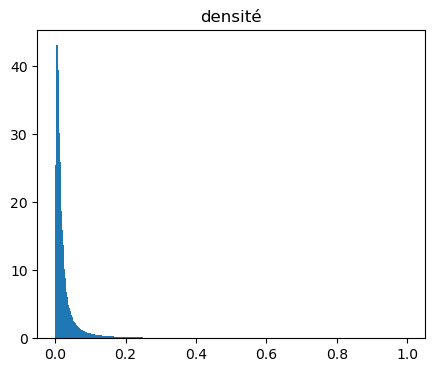

In [39]:
plt.figure(figsize=(5,4))
plt.hist(val,bins=500, density=True)
plt.title("densité")
#plt.xscale('log')
#plt.yscale('log')
plt.show()

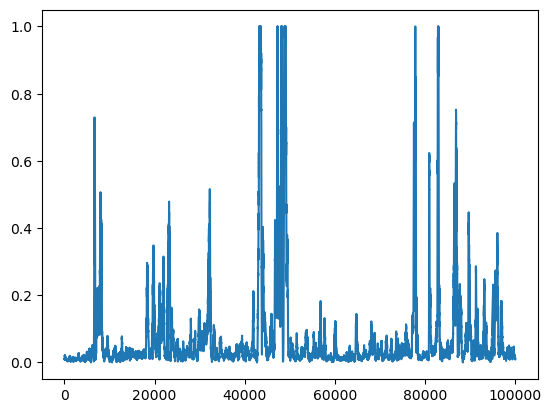

In [40]:
plt.plot((val[1000000:1100000]))

In [37]:
val=np.copy(valeurs)
val[val >= 2000] = 2000
val=val/2000
max(val)
max(valeurs)


8576.312

In [20]:
np.arange(10)[4::-1]

array([4, 3, 2, 1, 0])

In [11]:
#bigwig to sparse
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
values=[]
for file in fichiers:
    bw=pbg.open(file)
    array=np.concatenate((bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True),bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True)))
    values.append(sparse.csr_matrix(array))


In [59]:
#modèle

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(12)),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=(12)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
    ])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss_fn,
    optimizer='adam',
    metrics=['accuracy'])